# 5243 project4

## **1. Data pre-processing**

In [5]:
import numpy as np
import pandas as pd
import math
import copy
import itertools
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

In [6]:
url = 'https://raw.githubusercontent.com/LeeMere/ADS-Spring2024-Project4-MachineLearningFairness-Group7/main/data/compas-scores-two-years.csv'
df_raw = pd.read_csv(url)

In [7]:
df_raw.head()

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,...,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,...,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1
3,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,...,6,Medium,2013-01-13,NaN,NaN,1,0,1174,0,0
4,6,bouthy pierrelouis,bouthy,pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,...,1,Low,2013-03-26,NaN,NaN,2,0,1102,0,0


In [8]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7214 entries, 0 to 7213
Data columns (total 53 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       7214 non-null   int64  
 1   name                     7214 non-null   object 
 2   first                    7214 non-null   object 
 3   last                     7214 non-null   object 
 4   compas_screening_date    7214 non-null   object 
 5   sex                      7214 non-null   object 
 6   dob                      7214 non-null   object 
 7   age                      7214 non-null   int64  
 8   age_cat                  7214 non-null   object 
 9   race                     7214 non-null   object 
 10  juv_fel_count            7214 non-null   int64  
 11  decile_score             7214 non-null   int64  
 12  juv_misd_count           7214 non-null   int64  
 13  juv_other_count          7214 non-null   int64  
 14  priors_count            

In [9]:
# We can see there are some missing data exist, check with the missing data

missing_data = pd.DataFrame(df_raw.isna().sum()).sort_values(by = 0, ascending=False)
missing_data.columns = ["count"]
missing_data[missing_data["count"]!=0]

,count
violent_recid,7214
vr_charge_degree,6395
vr_case_number,6395
vr_offense_date,6395
vr_charge_desc,6395
c_arrest_date,6077
r_jail_out,4898
r_jail_in,4898
r_days_from_arrest,4898
r_charge_desc,3801


In [10]:
# Filter the DataFrame for the two races
df_filtered = df_raw[df_raw['race'].isin(['Caucasian', 'African-American'])]

In [11]:
# Feature selection
features = ['age', 'race', 'sex', 'decile_score', 'priors_count']  # Example features
X = df_filtered[features]
y = df_filtered['two_year_recid']

In [12]:
# Check missing values again
print("Missing values in the dataset:")
print(X.isnull().sum())
print(y.isnull().sum())

Missing values in the dataset:
age             0
race            0
sex             0
decile_score    0
priors_count    0
dtype: int64
0


In [13]:
# Map variable to a binary variable
X['race'] = X['race'].map({'Caucasian': 1, 'African-American': 0})
X['sex'] = X['sex'].map({'Female': 0, 'Male': 1})

<ipython-input-13-ec63ad40bd37>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['race'] = X['race'].map({'Caucasian': 1, 'African-American': 0})
<ipython-input-13-ec63ad40bd37>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['sex'] = X['sex'].map({'Female': 0, 'Male': 1})


In [14]:
X.head()

,age,race,sex,decile_score,priors_count
1,34,0,1,3,0
2,24,0,1,4,4
3,23,0,1,8,1
6,41,1,1,6,14
8,39,1,0,1,0


In [15]:
# Check the lengths of X and y to make sure they match
assert len(X) == len(y), "The lengths of X and y do not match."

In [16]:
df = pd.concat([X, y], axis=1)
df.head()

,age,race,sex,decile_score,priors_count,two_year_recid
1,34,0,1,3,0,1
2,24,0,1,4,4,1
3,23,0,1,8,1,0
6,41,1,1,6,14,1
8,39,1,0,1,0,0


In [34]:
#data splitting
train_size = int(len(df) * 0.714)
remainder_size = int(len(df) * 0.143)

train = df[:train_size]
remainder = df[train_size:]

validation = remainder[:remainder_size]
test = remainder[remainder_size:]

label = "two_year_recid"
sensitive = "race"
features = ['age', 'sex', 'decile_score', 'priors_count']
features_race = ['race', 'age', 'race', 'sex', 'decile_score', 'priors_count']

x_train, y_train, race_train = train[features], train[label].to_numpy(), train[sensitive]
x_val, y_val, race_val = validation[features], validation[label].to_numpy(), validation[sensitive]
x_test, y_test, race_test = test[features], test[label].to_numpy(), test[sensitive]

x_train_race, x_test_race, x_val_race = train[features_race], test[features_race], validation[features_race]

## **2. Baseline Model - Logistic Regression (Without Constraints)**

In [18]:
bsl = LogisticRegression().fit(x_train, y_train)

In [19]:
def calc_calibration(sensitive_attr, y_pred, y_true):
    cau_index = np.where(sensitive_attr == 1)[0]
    african_index = np.where(sensitive_attr == 0)[0]

    y_pred_cau = y_pred[cau_index]
    y_true_cau = y_true[cau_index]
    Acc_cau = sum(y_pred_cau == y_true_cau)/len(y_pred_cau)

    y_pred_african = y_pred[african_index]
    y_true_african = y_true[african_index]
    Acc_african = sum(y_pred_african == y_true_african)/len(y_pred_african)

    calibration = abs(Acc_cau - Acc_african)
    return(calibration)

In [20]:
#evaluating the baseline model
summary_bsl = {"Set": ["Train", "Validation", "Test"],
               "Accuracy":  [bsl.score(x_train, y_train), bsl.score(x_val, y_val), bsl.score(x_test, y_test)],
               "Calibration": [calc_calibration(race_train, bsl.predict(x_train), y_train),
                               calc_calibration(race_val, bsl.predict(x_val), y_val),
                               calc_calibration(race_test, bsl.predict(x_test), y_test)]}
pd.DataFrame(summary_bsl)

,Set,Accuracy,Calibration
0,Train,0.680938,0.012042
1,Validation,0.682594,0.005245
2,Test,0.650000,0.047773


## **3. Algorithm 1: Information Theoretic Measures for Fairness-aware Feature Selection(FFS)**

The goal for this algorithm is to select or omit features in a way that minimizes bias, such as race in our example, while optimizing the predictive performance of the model. In this method, we first quantify the accuracy and disccrimination impact of subsets of features based on information-theoretic measures. Then we calculate a fainess-utility score for each feature based on its contribution to both accurate predictions and nondiscriminatory outcomes. The method also utilizes Shapley analysis from cooperative game theory to determine the marginal impact of each feature.


### **3.1 Preparation (Defining Functions)**

**Problem formulation & Bivariate decomposition of information**: In this section, we are trying to define functions that help us to quantify the unique information in random variables R1 and R2 (features), and unique information in the conditional function.

Related formular: IQ(T; R1|R2) = ∑t,r1,r2 QT ,R1,R2 (t, r1, r2) log((QT |R1,R2 (t|r1,r2))/ (QT |R2 (t|r2)))

In [29]:
def unique_value_array(arr):
  unique_values = []
  for col in range(arr.shape[1]):
    unique_values.append(np.unique(arr[:, col]).tolist())
  return unique_values

def unique_information(arr1, arr2):
  assert arr1.shape[0] == arr2.shape[0]

  n_rows = arr1.shape[0]
  n_col_arr1 = arr1.shape[1]

  concated_arr = np.concatenate((arr1, arr2), axis=1)
  unique_arr = unique_value_array(concated_arr)
  cartesian_product = list(itertools.product(*unique_arr))

  # Define IQ
  IQ = 0
  for i in cartesian_product:
    r1_r2 = len(np.where((concated_arr == i).all(axis=1))[0]) / n_rows
    r1 = len(np.where((arr1 == i[:n_col_arr1]).all(axis=1))[0]) / n_rows
    r2 = len(np.where((arr2 == i[n_col_arr1:]).all(axis=1))[0]) / n_rows

    if r1_r2 == 0 or r1 == 0 or r2 == 0:
      IQ_iter = 0
    else:
      IQ_iter = r1_r2 * np.log(r1_r2 / r1) / r1
    IQ += np.abs(IQ_iter)
  return IQ

def unique_information_conditional(arr1, arr2, conditional):
  assert (arr1.shape[0] == arr2.shape[0]) and (arr1.shape[0] == conditional.shape[0])

  n_rows = arr1.shape[0]
  n_col_arr1 = arr1.shape[1]
  n_col_arr2 = arr2.shape[1]

  concated_arr2_conditional = np.concatenate((arr2, conditional), axis=1)
  concated_arr_all = np.concatenate((arr1, concated_arr2_conditional), axis = 1)
  unique_arr = unique_value_array(concated_arr_all)
  cartesian_product = list(itertools.product(*unique_arr))

  IQ = 0
  for i in cartesian_product:
    r1_r2 = len(np.where((concated_arr_all == i).all(axis=1))[0]) / n_rows
    r1    = len(np.where((arr1 == i[:n_col_arr1]).all(axis=1))[0]) / n_rows
    r2    = len(np.where((concated_arr_all[:, n_col_arr1: -n_col_arr2] == i[n_col_arr1: -n_col_arr2]).all(axis=1))[0]) / n_rows

    try:
      r1_given_r2 = len(np.where((concated_arr_all[:, :n_col_arr1] == i[ :n_col_arr1]).all(axis=1) & (concated_arr_all[:, -n_col_arr2:] == i[-n_col_arr2:]).all(axis=1))[0]) / len(np.where((concated_arr_all[:, -n_col_arr2:] == i[-n_col_arr2:]).all(axis=1))[0])

    except ZeroDivisionError:
      r1_given_r2 = 0

    if r1_r2 == 0 or r1 ==0 or r2 == 0 or r1_given_r2 == 0:
      IQ_iter = 0
    else:
      IQ_iter = r1_r2 * np.log(r1_r2 / r2) / r1_given_r2
    IQ += np.abs(IQ_iter)
  return IQ

**Quantifying accuracy & discriminatory effect:** In this section, we further seek to create an accuracy measure that accounts for the unique and synergistic information provided by subsets of features when making predictions. Here we define function for calculating *accuracy coefficient* and *discrimination coefficient*.

In [30]:
def acc_coef(y, x_s, x_s_c, A):
  conditional = np.concatenate((x_s_c, A), axis=1)
  return unique_information_conditional(y, x_s, conditional)

def dis_coef(y, x_s, A):
  x_s_a = np.concatenate((x_s, A), axis=1)
  return unique_information(y, x_s_a) * unique_information(x_s, A) * unique_information_conditional(x_s, A, y)


**Deifining power function**

In [31]:
def power_func(seq):
    if len(seq) <= 1:
        yield seq
        yield []
    else:
        for i in power_func(seq[1:]):
            yield [seq[0]] + i
            yield i

**Aggregation of Effects:** In this section, we define **Shapley value functions** to calculate *marginal accuracy* and *marginal discrimination* since the accuracy and discrimination measures we defined before do not consider the correlation among features and we cannot use them to calculate the marginal measures.

In [32]:
def marg_acc_coef(y_train, x_train, A, set_tracker):
  n_features = x_train.shape[1]
  feature_idx = list(range(n_features))
  feature_idx.pop(set_tracker)
  power_func_features = [x for x in power_func(feature_idx) if len(x) > 0]

  shapley_value =0
  for sc_idx in power_func_features:
        coef = math.factorial(len(sc_idx)) * math.factorial(n_features - len(sc_idx) - 1) / math.factorial(n_features)

        idx_xs_ui = copy.copy(sc_idx)
        idx_xs_ui.append(set_tracker)
        idx_xsc_ui = list(set(list(range(n_features))).difference(set(idx_xs_ui)))
        vTU = acc_coef(y_train.reshape(-1, 1), x_train[:, idx_xs_ui], x_train[:, idx_xsc_ui], A.reshape(-1, 1))

        idx_xsc = list(range(n_features))
        idx_xsc.pop(set_tracker)
        idx_xsc = list(set(idx_xsc).difference(set(sc_idx)))
        vT = acc_coef(y_train.reshape(-1, 1), x_train[:, sc_idx], x_train[:, idx_xsc], A.reshape(-1, 1))

        marginal = vTU - vT
        shapley_value = shapley_value + coef * marginal
  return shapley_value


def marg_dis_coef(y_train, x_train, A, set_tracker):
  n_features = x_train.shape[1]
  feature_idx = list(range(n_features))
  feature_idx.pop(set_tracker)
  power_func_features = [x for x in power_func(feature_idx) if len(x) > 0]

  shapley_value = 0
  for sc_idx in power_func_features:
      coef = math.factorial(len(sc_idx)) * math.factorial(n_features - len(sc_idx) - 1) / math.factorial(n_features)

      idx_xs_ui = copy.copy(sc_idx)
      idx_xs_ui.append(set_tracker)
      vTU = dis_coef(y_train.reshape(-1, 1), x_train[:, idx_xs_ui], A.reshape(-1, 1))

      vT = dis_coef(y_train.reshape(-1, 1), x_train[:, sc_idx], A.reshape(-1, 1))

      marginal = vTU - vT
      shapley_value = shapley_value + coef * marginal

  return shapley_value


### **3.2 Calculating Shapley value**

In [25]:
shapley_acc = []
shapley_dis = []

for i in range(4):
  acc_i = marg_acc_coef(y_train, x_train.to_numpy(), race_train.to_numpy(), i)
  dis_i = marg_dis_coef(y_train, x_train.to_numpy(), race_train.to_numpy(), i)

  shapley_acc.append(acc_i)
  shapley_dis.append(dis_i)

feature_names = ['Age', 'Sex', 'Decile Score', 'Priors Count']
shapley_df = pd.DataFrame(list(zip(feature_names, shapley_acc, shapley_dis)),
                          columns = ["Feature", "Accuracy", "Discrimination"])

shapley_df

,Feature,Accuracy,Discrimination
0,Age,0.939913,1.898180e+07
1,Sex,0.673040,2.797407e+06
2,Decile Score,0.926981,1.247128e+07
3,Priors Count,0.765247,1.403305e+07


Based on above results, it shows that 'Age' and 'Decile Score' have the greatest impact on model accuracy, and 'Age' has the stongest impact on discrimination. Therefore, dropping 'Age' seems to be a good choice. The next step is to calculate the fairness utility score for features. This qualifies the influences on decisions that are accurate and non-discriminational.

### **3.3 Calculating Fairness-Utility Scores**

Note: alpha is a hyperparameter that trades off between accuracy and discrimination, which means that if we think accuracy is more important, then we can set it as a lower value. It is mathematically defined as (Shapley accuracy - alpha * Shapley discrimination). Here we are going to discuss the fainess utility scores under different alpha's. First, let's define the fairness utility score:

In [26]:
def fairness_utility_score(acc, dis, alpha):
  scores = []
  for i in range(4):
    score = acc[i] - alpha * dis[i]
    scores.append(score)
  return scores

Create a range of alphas to plot (from 0 to a reasonable maximum given the scale of the discrimination values). So, we pick the maximum value of alpha as the inverse of the largest discrimination value to ensure meaningful utility scores

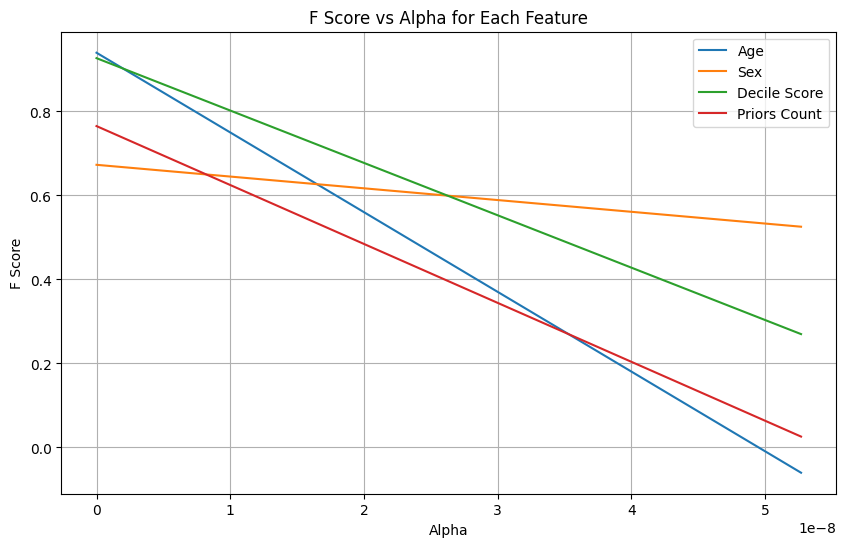

In [27]:
max_alpha = 1 / max(shapley_df['Discrimination'])
alphas = np.linspace(0, max_alpha, 100)

f_scores = {feature: [] for feature in shapley_df['Feature']}

for alpha in alphas:
    scores = fairness_utility_score(shapley_df['Accuracy'], shapley_df['Discrimination'], alpha)
    for feature, score in zip(shapley_df['Feature'], scores):
        f_scores[feature].append(score)

plt.figure(figsize=(10, 6))
for feature, scores in f_scores.items():
    plt.plot(alphas, scores, label=feature)

plt.title('F Score vs Alpha for Each Feature')
plt.xlabel('Alpha')
plt.ylabel('F Score')
plt.legend()
plt.grid(True)
plt.show()

From above plot we can see that if alpha is set above 3.5le-8, then 'Age' has the lowest score, which support our previous conclusion. Thus, we can drop 'Age' to make our model under less discriminational influence but still keep a good accuracy value.

### **3.4 Logistic Regression After Adjustment**

In [36]:
#data splitting
x_train_ffs = x_train.drop(['age'], axis=1)
x_test_ffs = x_test.drop(['age'], axis=1)
x_val_ffs = x_val.drop(['age'], axis=1)

bsl_ffs = LogisticRegression(random_state=0).fit(x_train_ffs, y_train)

In [37]:
#evaluating
summary_bsl_ffs = {"Set": ["Train", "Validation", "Test"],
               "Accuracy":  [bsl_ffs.score(x_train_ffs, y_train), bsl_ffs.score(x_val_ffs, y_val), bsl_ffs.score(x_test_ffs, y_test)],
               "Calibration": [calc_calibration(race_train, bsl_ffs.predict(x_train_ffs), y_train),
                               calc_calibration(race_val, bsl_ffs.predict(x_val_ffs), y_val),
                               calc_calibration(race_test, bsl_ffs.predict(x_test_ffs), y_test)]}
pd.DataFrame(summary_bsl_ffs)

,Set,Accuracy,Calibration
0,Train,0.670462,0.036115
1,Validation,0.678043,0.022429
2,Test,0.636364,0.069751


Compared to our baseline model, the accuracy slightly decreases by about 1%, but the calibration increases by more than 1%.

## 4. Algorithm 2: Learning Fair Representations

## 5. Summary